In [1]:
import os
import pandas as pd
from pathlib import Path

#from jsonschema.benchmarks.contains import beginning

Nr 
Panel 
1. 
Copper Indium Gallium Selenide (CIGS), a flexible 
module; 
nominal efficiency Specifications 
12.7% specs 
2. 
Cadmium Telluride (CdTe), a lower cost module; 
12.0% specs 
3. 
Polycrystalline Silicon (Poly-Si), the most commonly 
used technology; 
15.5% specs 
4. 
Interdigitated Back Contact monocrystalline silicon, 
charge extraction located at the back of the cell;  
21.5% specs 
5. 
Heterojunction Intrinsic Layer Monocrystalline Silicon 
(HIT Si), highest lab-tested efficiency; 
19.4% specs 
6. 
Copper Indium Gallium Selenide (CIGS) with reflective 
backing; 
14.7% specs

In [2]:
def get_selected_months(years=None, months=None):
    """
    Generate a list of selected months based on user input for years and months.
    
    Parameters:
        years (list of int): List of years to include (e.g., [2017, 2018]).
        months (list of int): List of months to include (e.g., [1, 2, 3]).
        
    Returns:
        list of str: List of selected year_month combinations (e.g., ['2017_01', '2017_02']).
    """
    if years is None:
        years = [2017]  # Default year
    if months is None:
        months = range(1, 13)  # Default to all months

    selected_months = [f"{year}_{str(month).zfill(2)}" for year in years for month in months]
    return selected_months

In [3]:
def load_and_sync_data(base_path, selected_months, selected_csvs, debug=False):
    base_path = Path(base_path)
    if not base_path.is_dir():
        raise FileNotFoundError(f"The base path does not exist: {base_path}")

    # Dictionary to store DataFrames from each source
    source_dataframes = {}

    for csv_type in selected_csvs:
        combined_source_data = []

        for month in selected_months:
            year, month_number = month.split('_')
            year_folder = f"{year}_V3"
            month_folder = f"{year}_{month_number}"
            month_path = base_path / year_folder / month_folder

            if not month_path.is_dir():
                if debug:
                    print(f"Skipping non-existent directory: {month_path}")
                continue

            # Determine the correct file name for the source
            file_name_with_space = f"{csv_type}- {month_folder}.csv"
            file_name_without_space = f"{csv_type}-{month_folder}.csv"

            file_path = None
            if csv_type == "LightSpectra":
                # Handle LightSpectra's unique naming format
                file_path_with_space = month_path / file_name_with_space
                file_path_without_space = month_path / file_name_without_space
                if file_path_with_space.exists():
                    file_path = file_path_with_space
                elif file_path_without_space.exists():
                    file_path = file_path_without_space
            else:
                file_path = month_path / file_name_without_space

            if file_path and file_path.exists():
                try:
                    data_frame = pd.read_csv(file_path, low_memory=False)

                    # -------------------
                    # Standardize date/time columns
                    # -------------------
                    data_frame["Year"] = data_frame.get("Date[year]", year)
                    data_frame["Month"] = data_frame.get("Date[month]", month_number)
                    data_frame["Day"] = data_frame.get("Date[day]")
                    data_frame["Weekday"] = data_frame.get("Date[weekday]")

                    if "Time[hh:mm:ss]" in data_frame.columns:
                        data_frame["Time"] = data_frame["Time[hh:mm:ss]"]
                        data_frame.drop(columns=["Time[hh:mm:ss]"], errors="ignore", inplace=True)

                    data_frame.drop(
                        columns=[col for col in data_frame.columns if col.startswith("Date[")],
                        errors="ignore",
                        inplace=True
                    )

                    data_frame["Source"] = csv_type  # (optional metadata)
                    combined_source_data.append(data_frame)

                except Exception as e:
                    if debug:
                        print(f"Error loading file {file_path}: {e}")
            else:
                if debug:
                    print(f"File not found: {file_path}")

        # Concatenate all data for the current source
        if combined_source_data:
            source_dataframes[csv_type] = pd.concat(combined_source_data, ignore_index=True)

    # -------------------
    # Merge (inner join) across all sources on "AbsTime[s]"
    # -------------------
    synced_data = None
    for source, df in source_dataframes.items():
        if synced_data is None:
            synced_data = df
        else:
            synced_data = pd.merge(
                synced_data,
                df,
                on='AbsTime[s]',
                how='inner',
                suffixes=('', f'_{source}')
            )

    # -------------------
    # Consolidate duplicate columns
    # -------------------
    if synced_data is not None:
        for col in ["Year", "Month", "Day", "Time", "Weekday"]:
            # Gather all columns that start with "Year", "Month", etc.
            cols_to_merge = [c for c in synced_data.columns if c.startswith(col)]
            if len(cols_to_merge) > 1:
                # Fill "master" col with first non-NaN going left->right
                synced_data[col] = synced_data[cols_to_merge].bfill(axis=1).iloc[:, 0]
                # Drop duplicates except for the original "col"
                cols_to_drop = [c for c in cols_to_merge if c != col]
                synced_data.drop(columns=cols_to_drop, inplace=True, errors="ignore")

        # Remove the "Source" columns if no longer needed
        synced_data.drop(
            columns=[col for col in synced_data.columns if "Source" in col],
            errors="ignore",
            inplace=True
        )

        # Remove exact duplicated columns (rare leftover edge case)
        synced_data = synced_data.loc[:, ~synced_data.columns.duplicated()]

        return synced_data

    # If no data was found at all
    return pd.DataFrame()


if __name__ == "__main__":
    # Base path to the dataset
    base_path = "../../OneDrive - HvA/Jaar_4/PV systems modeling and analysis/Data/data_folder"
    base_path_bono = "../../school/4e jaar/PV systems modeling and analysis/Data/data_folder"

    # Specify months and sources to include
    selected_months = get_selected_months(years=[2021], months=[5,6])
    selected_csvs = ["SolarFieldData"]

    # Load and synchronize data
    synced_df = load_and_sync_data(base_path_bono, selected_months, selected_csvs, debug=True)

    # Display the synchronized DataFrame
    print("\nSynchronized DataFrame:")
    print(synced_df.head())

    # # Save the synchronized data for later use (optional)
    # synced_df.to_csv("synced_data_january_2017_2018.csv", index=False)
    # print("Synchronized data saved to synced_data_january_2017_2018.csv")



Synchronized DataFrame:
   AbsTime[s]  Act Air Density (WeatherStation)  \
0  3828816000                               NaN   
1  3828816300                               NaN   
2  3828816600                               NaN   
3  3828816900                               NaN   
4  3828817200                               NaN   

   Act Wind Direction (WeatherStation)  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   

   Act Wind Measurement Quality (WeatherStation)  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

   Act Wind Speed [km/h] (WeatherStation)  \
0                                     NaN   
1           

In [4]:
synced_df

,AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),...,Clear light (LAD Sensor 12),Infrared light (LAD Sensor 12),Temperature [°C] (LAD Sensor 12),Gain (LAD Sensor 12),Integration time (LAD Sensor 12),Year,Month,Day,Weekday,Time
0,3828816000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2021,May,1,Saturday,00:00:00
1,3828816300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.8,0.0,192.0,2021,May,1,Saturday,00:05:00
2,3828816600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:10:00
3,3828816900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:15:00
4,3828817200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17563,3834084900,1.221169,0.0000,100.0,0.000000,1015.896,15.08232,12.95173,87.10642,1.201355,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:35:00
17564,3834085200,1.221149,0.0000,100.0,0.000000,1015.932,15.06875,12.92241,87.01555,1.291014,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:40:00
17565,3834085500,1.221200,0.0000,100.0,0.000000,1015.962,15.04553,12.88310,86.92194,1.174879,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:45:00
17566,3834085800,1.220924,0.0000,100.0,0.000000,1015.987,15.09856,12.91005,86.77888,0.000000,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:50:00


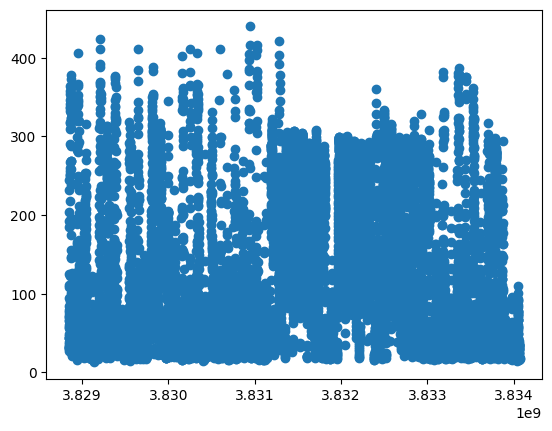

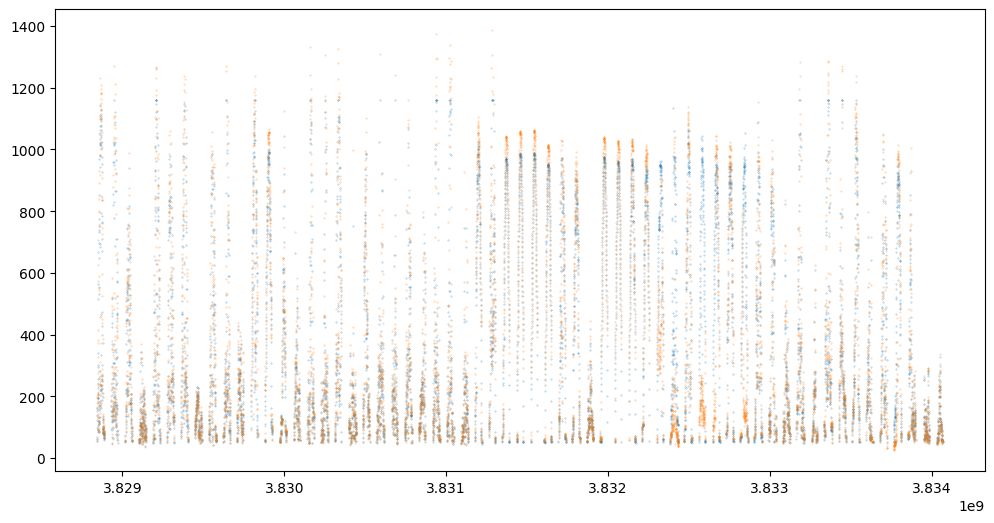

In [5]:
import matplotlib.pyplot as plt
plt.scatter(synced_df['AbsTime[s]'], synced_df['Pmpp[W]_3 (Solarpanel parameters)'])

plt.show()
plt.figure(figsize=(12, 6))
plt.scatter(synced_df['AbsTime[s]'], synced_df['G[W/mï½²]_3 (Solarpanel parameters)'],alpha=0.5,s=0.1)
plt.scatter(synced_df['AbsTime[s]'], synced_df['G_pyranometer[W/mï½²]_3 (Solarpanel parameters)'],alpha=0.5,s=0.1)

In [6]:
# 1) Maandnaam omzetten naar maandnummer
month_map = {
    'January': '01',
    'February': '02',
    'March': '03',
    'April': '04',
    'May': '05',
    'June': '06',
    'July': '07',
    'August': '08',
    'September': '09',
    'October': '10',
    'November': '11',
    'December': '12'
}
synced_df['Month_num'] = synced_df['Month'].map(month_map)

# 2) De kolommen Year, Month_num, Day en Time samenvoegen tot een datumstring
synced_df['datetime_str'] = (
    synced_df['Year'].astype(str) + '-' +
    synced_df['Month_num'].astype(str) + '-' +
    synced_df['Day'].astype(str) + ' ' +
    synced_df['Time'].astype(str)
)

# 3) Deze string parsen naar een datetime-kolom
synced_df['datetime'] = pd.to_datetime(synced_df['datetime_str'], format='%Y-%m-%d %H:%M:%S')

# 4) Zet deze nieuwe kolom als index van je DataFrame
synced_df.set_index('datetime', inplace=True)

# 5) (Optioneel) Opruimen: als je de losse kolommen niet meer nodig hebt:
synced_df.drop(columns=['Month_num', 'datetime_str'], inplace=True)

synced_df

,AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),...,Clear light (LAD Sensor 12),Infrared light (LAD Sensor 12),Temperature [°C] (LAD Sensor 12),Gain (LAD Sensor 12),Integration time (LAD Sensor 12),Year,Month,Day,Weekday,Time
datetime,,,,,,,,,,,,,,,,,,,,,
2021-05-01 00:00:00,3828816000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2021,May,1,Saturday,00:00:00
2021-05-01 00:05:00,3828816300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.8,0.0,192.0,2021,May,1,Saturday,00:05:00
2021-05-01 00:10:00,3828816600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:10:00
2021-05-01 00:15:00,3828816900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:15:00
2021-05-01 00:20:00,3828817200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 23:35:00,3834084900,1.221169,0.0000,100.0,0.000000,1015.896,15.08232,12.95173,87.10642,1.201355,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:35:00
2021-06-30 23:40:00,3834085200,1.221149,0.0000,100.0,0.000000,1015.932,15.06875,12.92241,87.01555,1.291014,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:40:00
2021-06-30 23:45:00,3834085500,1.221200,0.0000,100.0,0.000000,1015.962,15.04553,12.88310,86.92194,1.174879,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:45:00


In [7]:
# AbsTime[s],
# Act Air Density (WeatherStation),
# Act Wind Direction (WeatherStation),
# Act Wind Measurement Quality (WeatherStation),
# Act Wind Speed [km/h] (WeatherStation),
# Avg Absolute Air Pressure (WeatherStation),
# Avg Air Temperature (WeatherStation),
# Avg Dewpoint Temperature (WeatherStation),
# Avg Relative Humidity (WeatherStation),
# Avg Wind Speed [km/h] (WeatherStation),
# Precipitation Intensity [mm/h] (WeatherStation),
# Precipitation Type (WeatherStation),
# Module #_1 (Solarpanel parameters),
# Vmpp[V]_1 (Solarpanel parameters),
# Impp[A]_1 (Solarpanel parameters),
# Pmpp[W]_1 (Solarpanel parameters),
# Voc[V]_1 (Solarpanel parameters),
# Isc[A]_1 (Solarpanel parameters),
# FF[%]_1 (Solarpanel parameters),
# G[W/mï½²]_1 (Solarpanel parameters),
# Tmodul[ï½°C]_1 (Solarpanel parameters),
# G_pyranometer[W/mï½²]_1 (Solarpanel parameters),
# V Range_1 (Solarpanel parameters),
# I Range_1 (Solarpanel parameters),
# Scan Rate[S/sec.]_1 (Solarpanel parameters),
# Observed Efficiency_1 (Solarpanel parameters),
# Year,Month,Day,Weekday,Time

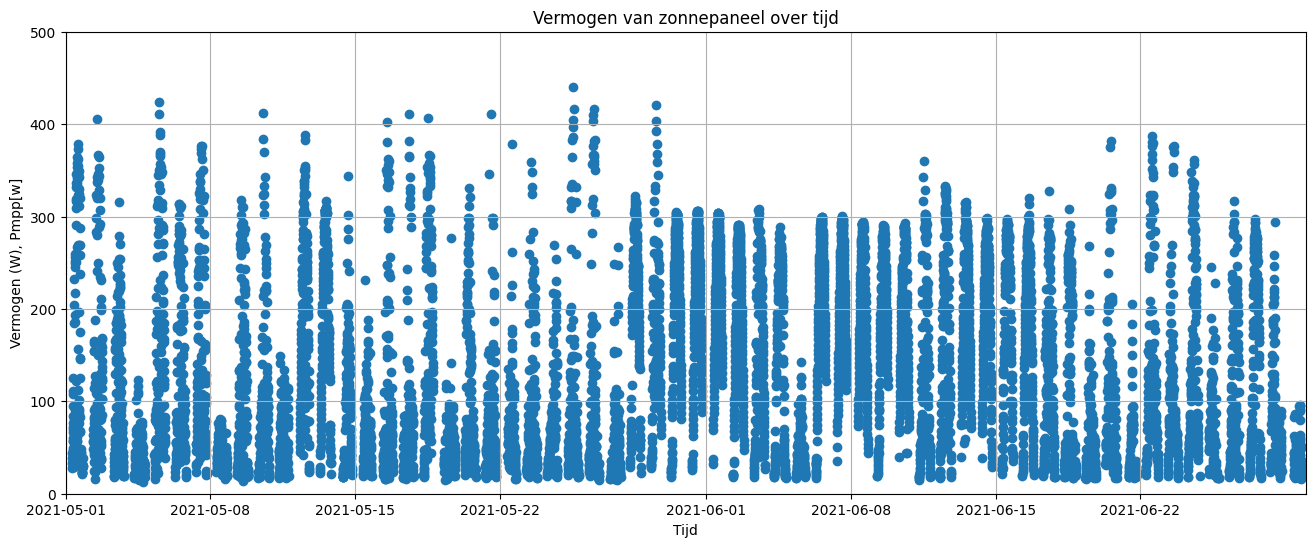

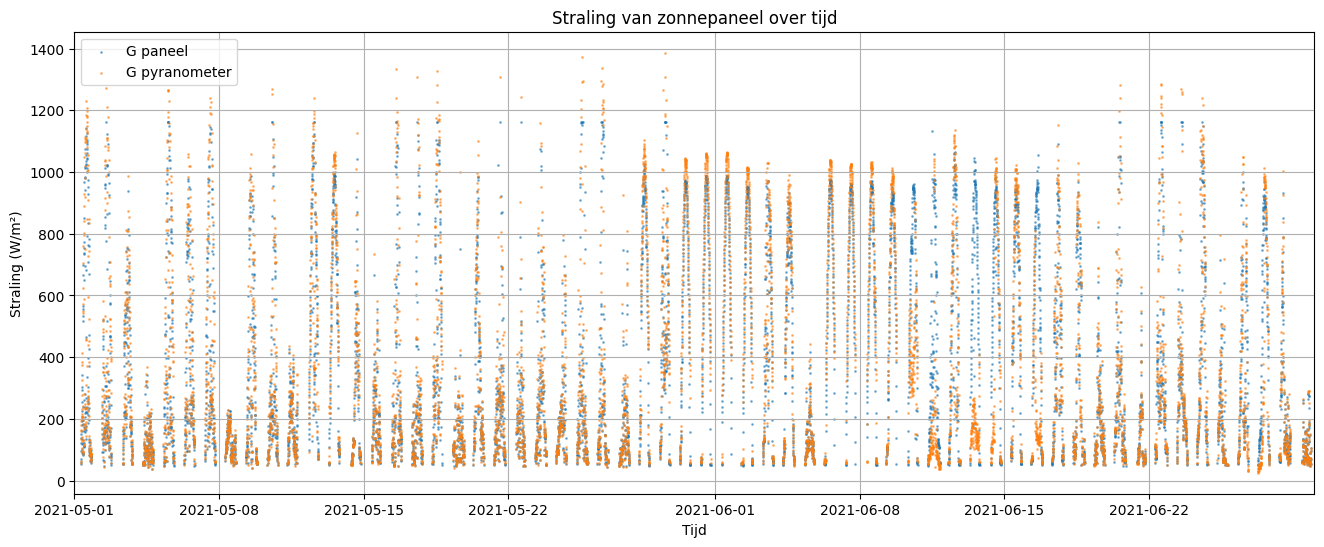

NameError: name 'np' is not defined

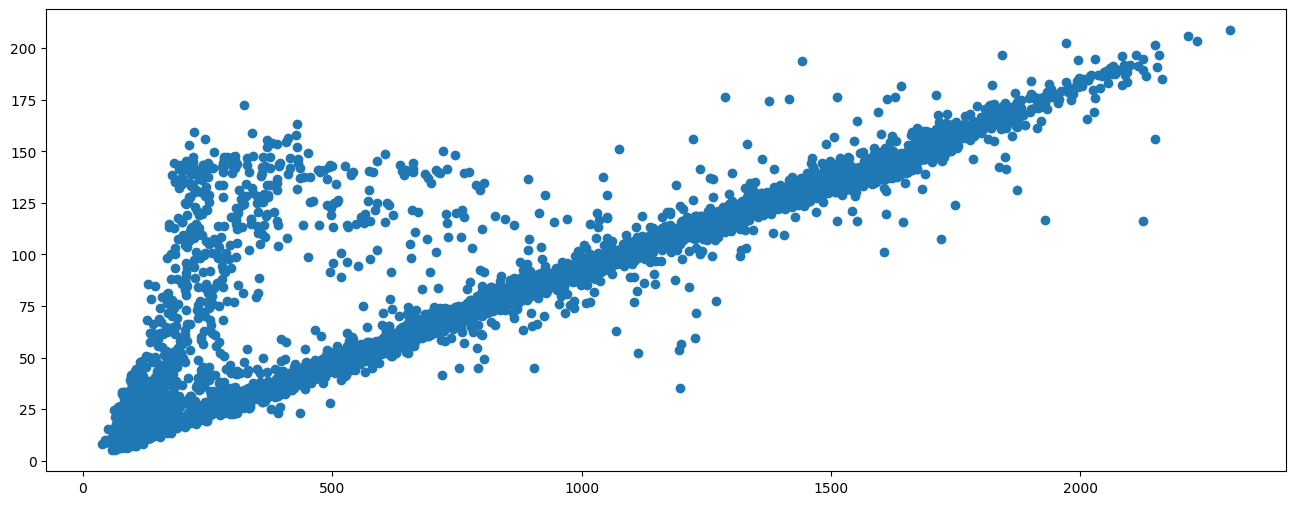

In [9]:
%matplotlib inline
begin = pd.Timestamp('2021-05-01')
end = pd.Timestamp('2021-06-30')

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.scatter(synced_df.index, synced_df['Pmpp[W]_3 (Solarpanel parameters)'])
plt.xlabel('Tijd')
plt.ylabel('Vermogen (W), Pmpp[w]')
plt.title('Vermogen van zonnepaneel over tijd')
plt.xlim(begin,end)
plt.ylim(0,500)
plt.grid()

plt.show()
plt.figure(figsize=(16, 6))
#plt.scatter(synced_df.index, synced_df['Pmpp[W]_3 (Solarpanel parameters)'],alpha=0.5,s=0.1)
plt.scatter(synced_df.index, synced_df['G[W/mï½²]_3 (Solarpanel parameters)'],alpha=0.5,s=1,label='G paneel')
plt.scatter(synced_df.index, synced_df['G_pyranometer[W/mï½²]_3 (Solarpanel parameters)'],alpha=0.5,s=1, label='G pyranometer')
plt.xlabel('Tijd')
plt.ylabel('Straling (W/m²)')
plt.title('Straling van zonnepaneel over tijd')
plt.xlim(begin,end)
plt.grid()
plt.legend()
plt.show()

begin_rendement = begin #pd.Timestamp('2021-05-1')
end_rendement = end #pd.Timestamp('2021-06-30')

maandenchecken = synced_df.loc[begin_rendement:end_rendement].copy()

plt.figure(figsize=(16, 6))
plt.scatter(maandenchecken['G_pyranometer[W/mï½²]_6 (Solarpanel parameters)']*1.65,maandenchecken['Pmpp[W]_6 (Solarpanel parameters)'])
x = np.linspace(0, 1000, 100)
plt.plot(x, x*0.20, 'r')
plt.xlabel('Straling van zon (W)')
plt.ylabel('Vermogen van zonnepaneel (W)')
plt.title('Vermogen van zonnepaneel vs Straling')
plt.grid()
plt.xlim(0,2500)
plt.ylim(0,500)
plt.show()

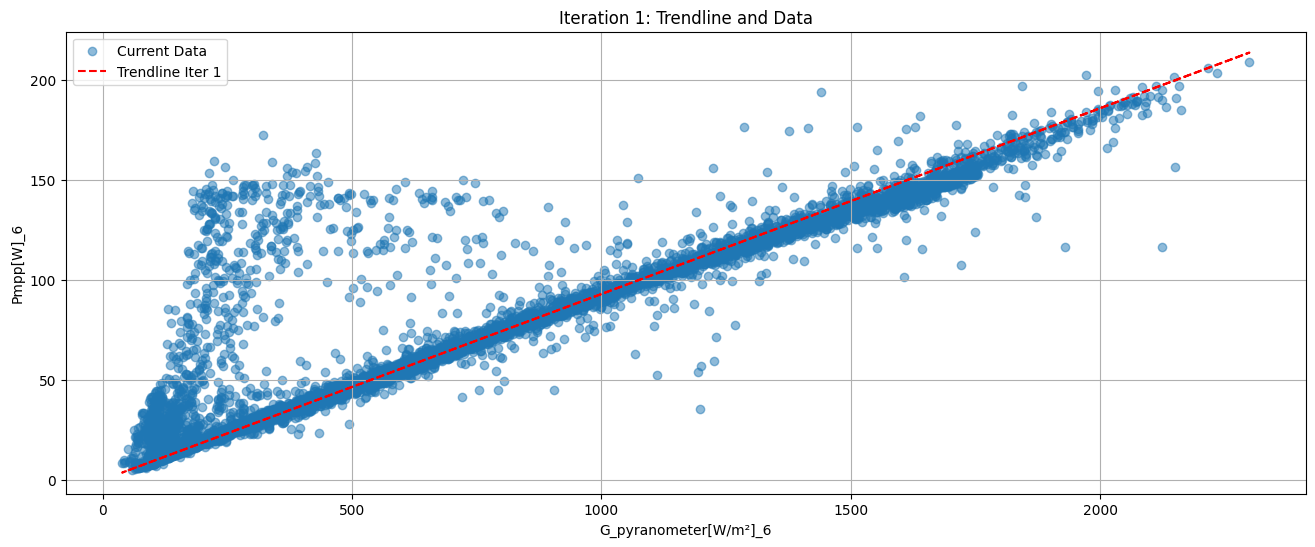

Iteration 1: y = 0.09x
Iteration 1: Removed 327 outliers.


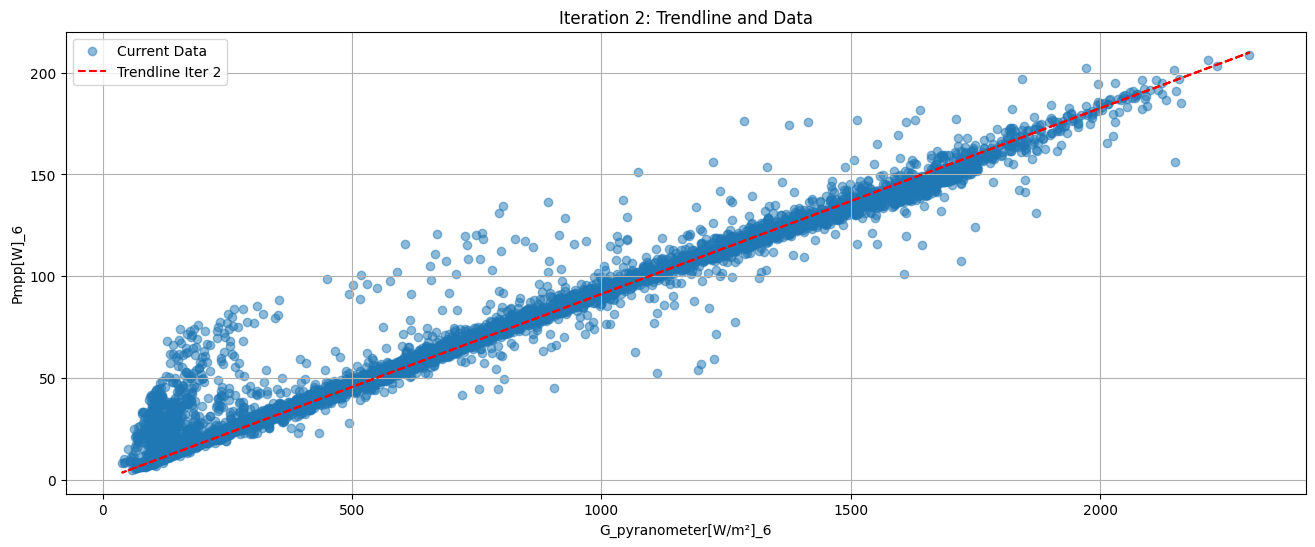

Iteration 2: y = 0.09x
Iteration 2: Removed 248 outliers.


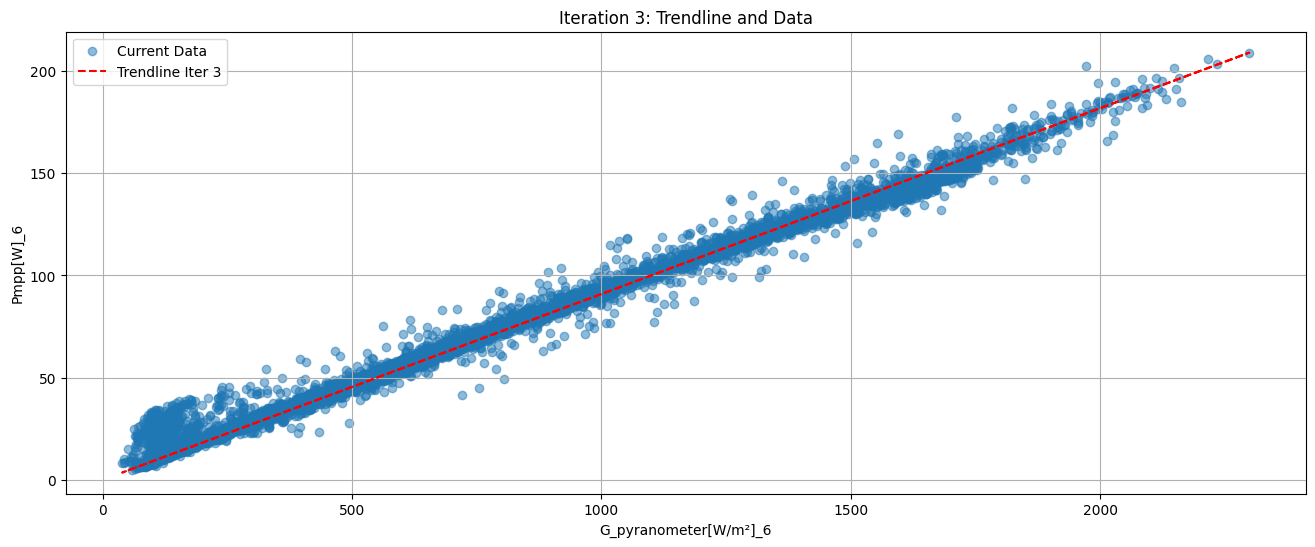

Iteration 3: y = 0.09x
Iteration 3: Removed 260 outliers.


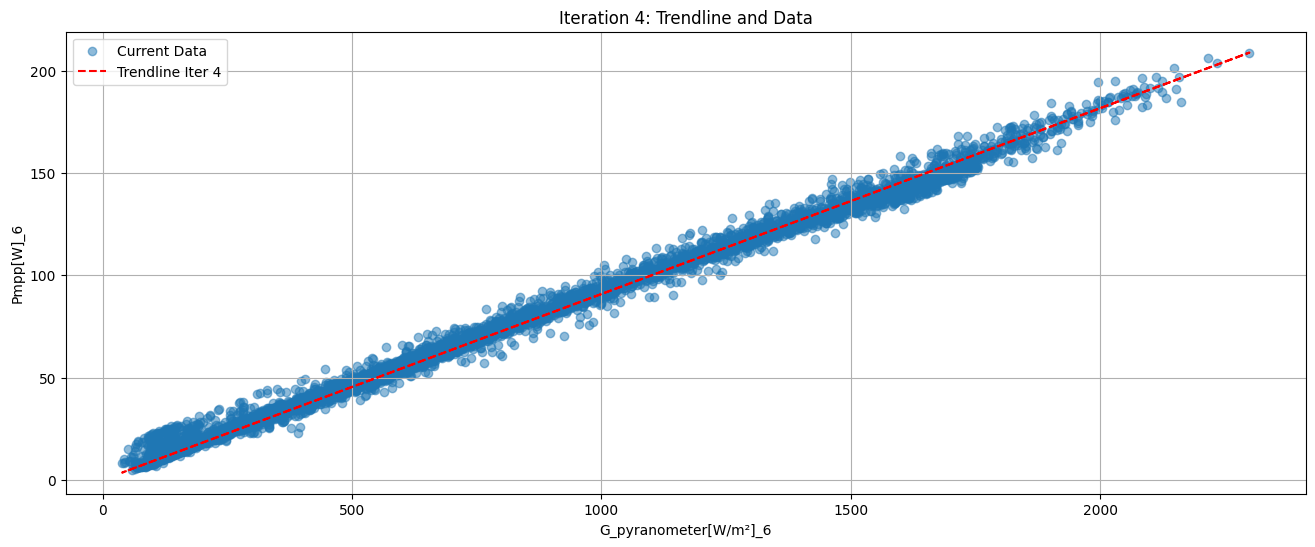

Iteration 4: y = 0.09x
Iteration 4: Removed 179 outliers.


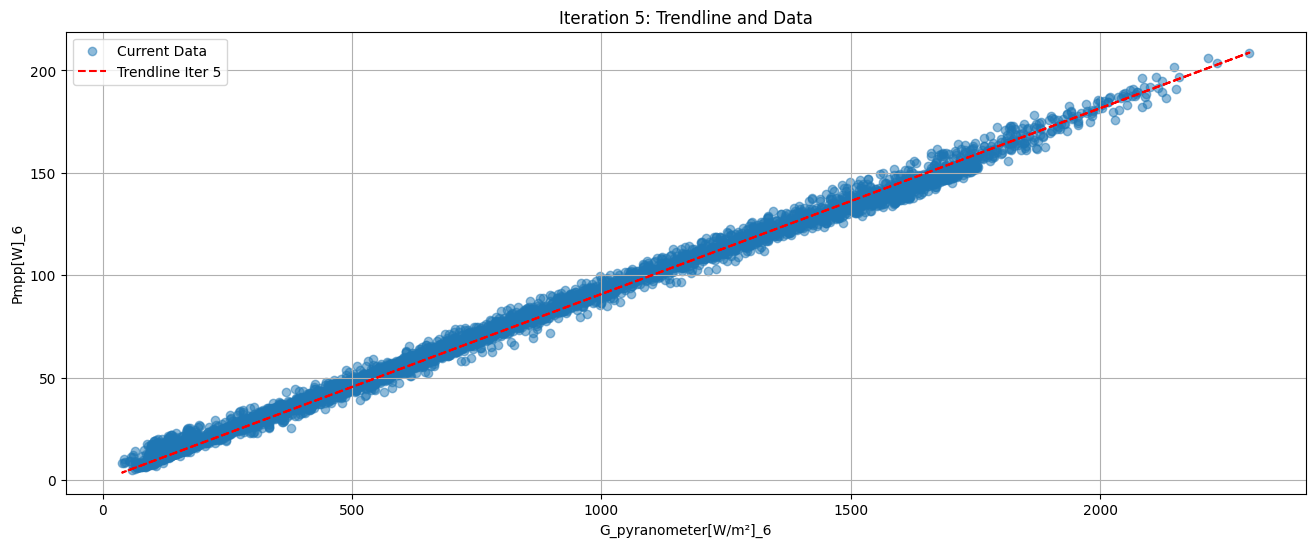

Iteration 5: y = 0.09x
Iteration 5: Removed 105 outliers.


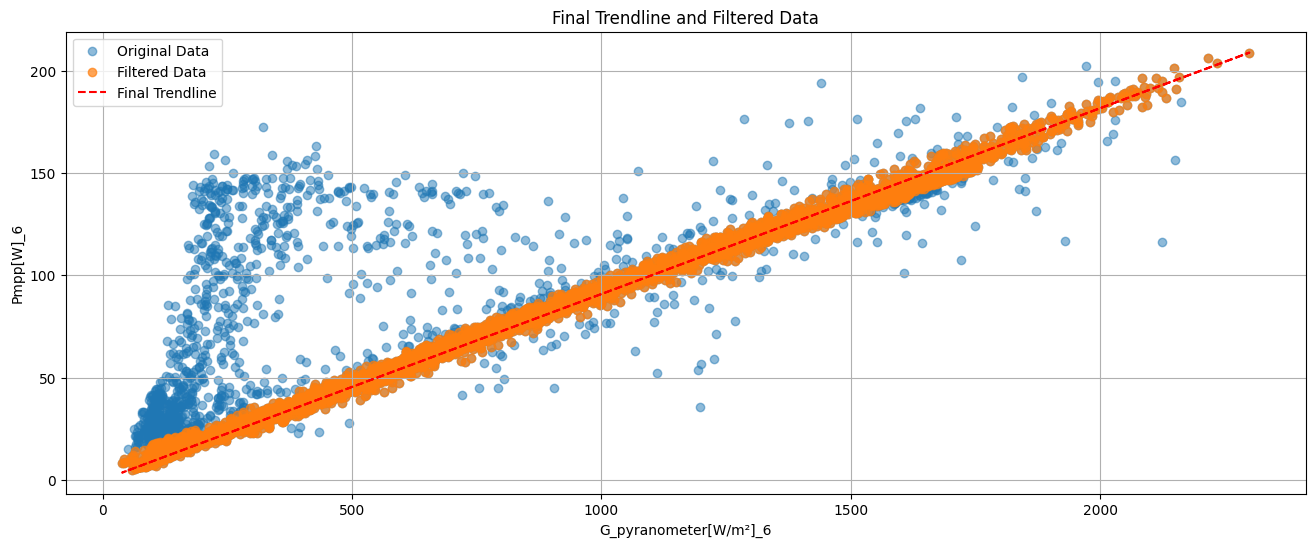

Final Trendline: y = 0.09x


,AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),...,Temperature [°C] (LAD Sensor 12),Gain (LAD Sensor 12),Integration time (LAD Sensor 12),Year,Month,Day,Weekday,Time,x,y
datetime,,,,,,,,,,,,,,,,,,,,,
2021-05-01 07:40:00,3828843600,1.254171,274.9478,100.0,1.263555,1014.983,7.849673,4.481034,79.27757,0.000000,...,12.5,0.0,192.0,2021,May,1,Saturday,07:40:00,93.885,12.619
2021-05-01 07:45:00,3828843900,1.253278,0.0000,100.0,0.000000,1015.017,7.985149,4.476882,78.52754,0.000000,...,13.2,0.0,192.0,2021,May,1,Saturday,07:45:00,104.775,15.491
2021-05-01 07:50:00,3828844200,1.252931,215.4218,100.0,3.023074,1015.103,8.223319,4.593984,77.90422,1.735225,...,14.2,0.0,192.0,2021,May,1,Saturday,07:50:00,258.225,22.451
2021-05-01 07:55:00,3828844500,1.252172,252.3136,100.0,1.941241,1015.179,8.188429,4.462746,77.37485,1.371645,...,15.8,0.0,192.0,2021,May,1,Saturday,07:55:00,232.650,19.626
2021-05-01 08:05:00,3828845100,1.251247,190.1064,100.0,2.039250,1015.134,8.558934,4.624562,76.31564,1.520583,...,17.2,0.0,192.0,2021,May,1,Saturday,08:05:00,297.000,23.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-29 19:25:00,3833983500,1.209372,187.6491,100.0,5.572020,1013.254,16.917380,14.182340,83.93651,2.328395,...,20.5,0.0,192.0,2021,June,29,Tuesday,19:25:00,249.975,22.936
2021-06-29 19:30:00,3833983800,1.208927,299.8468,100.0,2.882967,1013.286,17.031370,14.230000,83.59035,3.331224,...,21.5,0.0,192.0,2021,June,29,Tuesday,19:30:00,111.870,10.073
2021-06-29 19:35:00,3833984100,1.208520,238.2829,100.0,6.478311,1013.278,17.091160,14.268260,83.48077,1.996748,...,21.8,0.0,192.0,2021,June,29,Tuesday,19:35:00,177.375,16.642


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `synced_df` is already defined
begin_rendement = begin  # Replace `begin` with your actual start timestamp
end_rendement = end      # Replace `end` with your actual end timestamp

# Extract data for the specified time range
maandenchecken = synced_df.loc[begin_rendement:end_rendement].copy()

# Extract x and y values
x = maandenchecken['G_pyranometer[W/mï½²]_6 (Solarpanel parameters)'] * 1.65
y = maandenchecken['Pmpp[W]_6 (Solarpanel parameters)']

# Add x and y columns to maandenchecken for tracking
maandenchecken['x'] = x
maandenchecken['y'] = y

# Function to iteratively fit and remove outliers (slope-only)
def iterative_fit_and_filter(data, x_col, y_col, threshold=3, max_iterations=5):
    x = pd.to_numeric(data[x_col], errors='coerce')
    y = pd.to_numeric(data[y_col], errors='coerce')

    # Remove initial NaN values
    mask = ~x.isna() & ~y.isna()
    x = x[mask]
    y = y[mask]
    filtered_data = data[mask].copy()

    for iteration in range(max_iterations):
        # Fit a slope-only line (zero-intercept)
        slope = np.sum(x * y) / np.sum(x ** 2)
        
        # Calculate residuals
        residuals = y - (slope * x)
        std_residuals = np.std(residuals)

        # Identify points far from the trendline
        outliers = np.abs(residuals) > threshold * std_residuals

        if not outliers.any():
            print(f"No more outliers found after {iteration} iterations.")
            break

        # Plot intermediate results
        plt.figure(figsize=(16, 6))
        plt.scatter(x, y, alpha=0.5, label='Current Data')
        plt.plot(x, slope * x, "r--", label=f'Trendline Iter {iteration + 1}')
        plt.xlabel('G_pyranometer[W/m²]_6')
        plt.ylabel('Pmpp[W]_6')
        plt.title(f'Iteration {iteration + 1}: Trendline and Data')
        plt.legend()
        plt.grid()
        plt.show()

        # Print equation of the line
        print(f"Iteration {iteration + 1}: y = {slope:.2f}x")

        # Remove outliers
        filtered_mask = ~outliers
        x = x[filtered_mask]
        y = y[filtered_mask]
        filtered_data = filtered_data[filtered_mask].copy()

        print(f"Iteration {iteration + 1}: Removed {outliers.sum()} outliers.")

    # Final fit (slope-only)
    final_slope = np.sum(x * y) / np.sum(x ** 2)

    # Plot final results
    plt.figure(figsize=(16, 6))
    plt.scatter(data[x_col], data[y_col], alpha=0.5, label='Original Data')
    plt.scatter(x, y, alpha=0.7, label='Filtered Data')
    plt.plot(x, final_slope * x, "r--", label='Final Trendline')
    plt.xlabel('G_pyranometer[W/m²]_6')
    plt.ylabel('Pmpp[W]_6')
    plt.title('Final Trendline and Filtered Data')
    plt.legend()
    plt.grid()
    plt.show()

    # Print final equation of the line
    print(f"Final Trendline: y = {final_slope:.2f}x")

    return filtered_data, final_slope

# Apply the function
filtered_df, final_slope = iterative_fit_and_filter(maandenchecken, 'x', 'y')

# Display filtered DataFrame
filtered_df


In [12]:
import pvlib

from pvlib.modelchain import ModelChain
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

In [13]:
import pvlib
import pandas as pd

# Locatiegegevens
locatie_naam = "amolf"       # Naam van de locatie
latitude = 52.3676           # Breedtegraad in graden (Amsterdam)
longitude = 4.9041           # Lengtegraad in graden (Amsterdam)
timezone = "Europe/Amsterdam"

# PVWatts parameters gebaseerd op de datasheet van SolarWorld Plus SW 255 poly
pdc0 = 255                   # Nominaal vermogen van het paneel in Wp
gamma_pdc = -0.0045          # Vermogens-temperatuurcoëfficiënt in 1/°C
surface_tilt = 45            # Hellingshoek van het paneel in graden
surface_azimuth = 180        # Oriëntatie van het paneel in graden (180 = zuiden)
eta_inv_nom = 0.96           # Nominaal inverterrendement
eta_inv_ref = 0.96           # Referentierendement van de omvormer
albedo = 0.2                 # Reflectiecoëfficiënt (0.2 voor gras)
paneel_oppervlakte = 1.68    # Oppervlakte van het paneel in m²

# Locatie instellen
location = pvlib.location.Location(latitude=latitude, longitude=longitude, tz=timezone, name=locatie_naam)

# Kopieer de DataFrame om de originele data niet te wijzigen
data = filtered_df.copy()

# Weerdata voorbereiden
weather = pd.DataFrame(index=data.index)
weather["temp_air"] = data.get("Avg Air Temperature (WeatherStation)", 20.0)
weather["wind_speed"] = data.get("Avg Wind Speed [km/h] (WeatherStation)", 3.6) / 3.6
weather["ghi"] = data["G_pyranometer[W/mï½²]_3 (Solarpanel parameters)"]

# Voeg lege kolommen voor dni en dhi toe (wordt intern afgeleid door PVWatts)
weather["dni"] = None
weather["dhi"] = None

from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

# Kies het temperatuurmodel voor open-rack panelen (glas-glas)
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# PVWatts systeem instellen met correcte inverter_parameters
system = pvlib.pvsystem.PVSystem(
    surface_tilt=surface_tilt,
    surface_azimuth=surface_azimuth,
    module_parameters={'pdc0': pdc0, 'gamma_pdc': gamma_pdc},
    inverter_parameters={'pdc0': pdc0},  # Nominaal vermogen van de omvormer (zelfde als paneelvermogen)
    temperature_model_parameters=temperature_model_parameters
)



# ModelChain instellen en runnen met PVWatts
mc = pvlib.modelchain.ModelChain(
    system, location, dc_model='pvwatts', ac_model='pvwatts',
    aoi_model='no_loss', spectral_model='no_loss'
)
mc.run_model(weather)

# Output omrekenen naar W/m²
dc_power_per_m2 = mc.results.dc / paneel_oppervlakte  # DC output in W/m²
ac_power_per_m2 = mc.results.ac / paneel_oppervlakte  # AC output in W/m²

# Resultaten bekijken
print("DC power output (W/m²):", dc_power_per_m2)
print("AC power output (W/m²):", ac_power_per_m2)


DC power output (W/m²): datetime
2021-05-01 07:40:00    0.333922
2021-05-01 07:45:00    0.376781
2021-05-01 07:50:00    0.956083
2021-05-01 07:55:00    0.804619
2021-05-01 08:05:00    1.070916
                         ...   
2021-06-29 19:25:00    0.877009
2021-06-29 19:30:00    0.401652
2021-06-29 19:35:00     0.60508
2021-06-29 19:40:00    0.560802
2021-06-29 19:45:00    0.312859
Name: p_mp, Length: 7283, dtype: object
AC power output (W/m²): datetime
2021-05-01 07:40:00    0.000000
2021-05-01 07:45:00    0.000000
2021-05-01 07:50:00    0.046694
2021-05-01 07:55:00    0.000000
2021-05-01 08:05:00    0.159437
                         ...   
2021-06-29 19:25:00    0.000000
2021-06-29 19:30:00    0.000000
2021-06-29 19:35:00    0.000000
2021-06-29 19:40:00    0.000000
2021-06-29 19:45:00    0.000000
Name: p_mp, Length: 7283, dtype: float64


C:\Users\bono\anaconda3\envs\PV-Systems-Data2\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in maximum
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\bono\anaconda3\envs\PV-Systems-Data2\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\bono\anaconda3\envs\PV-Systems-Data2\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in maximum
  result = getattr(ufunc, method)(*inputs, **kwargs)


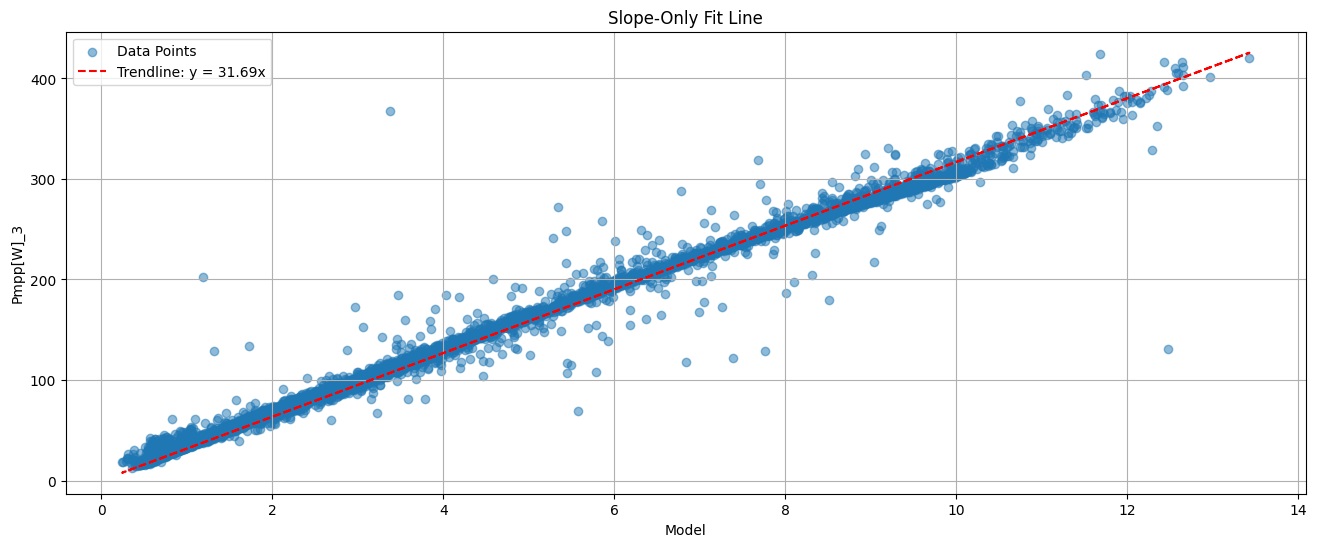

Trendline Equation: y = 31.69x


(datetime
 2021-05-01 07:40:00    0.560989
 2021-05-01 07:45:00    0.632992
 2021-05-01 07:50:00    1.606220
 2021-05-01 07:55:00    1.351759
 2021-05-01 08:05:00    1.799139
                          ...   
 2021-06-29 19:25:00    1.473375
 2021-06-29 19:30:00    0.674775
 2021-06-29 19:35:00    1.016535
 2021-06-29 19:40:00    0.942147
 2021-06-29 19:45:00    0.525603
 Name: Model, Length: 7278, dtype: float64,
 datetime
 2021-05-01 07:40:00    27.769
 2021-05-01 07:45:00    33.301
 2021-05-01 07:50:00    39.011
 2021-05-01 07:55:00    43.629
 2021-05-01 08:05:00    57.414
                         ...  
 2021-06-29 19:25:00    50.037
 2021-06-29 19:30:00    23.053
 2021-06-29 19:35:00    35.219
 2021-06-29 19:40:00    31.681
 2021-06-29 19:45:00    17.720
 Name: Pmpp[W]_3 (Solarpanel parameters), Length: 7278, dtype: float64)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Replace with actual data sources
# Assuming `mc.results.dc` and `data['Pmpp[W]_3 (Solarpanel parameters)']` are already defined
mc_results_dc = mc.results.dc  # Using your provided source directly
pmpp = data['Pmpp[W]_3 (Solarpanel parameters)']  # Using your provided source directly

# Creating DataFrame
data = pd.DataFrame({
    "Model": mc_results_dc,
    "Pmpp[W]_3 (Solarpanel parameters)": pmpp  # y values
})

# Function to fit and plot a slope-only regression line
def fit_and_plot(data, x_col, y_col):
    x = pd.to_numeric(data[x_col], errors='coerce')
    y = pd.to_numeric(data[y_col], errors='coerce')

    # Remove initial NaN values
    mask = ~x.isna() & ~y.isna()
    x = x[mask]
    y = y[mask]

    # Fit a slope-only line (zero-intercept)
    slope = np.sum(x * y) / np.sum(x ** 2)

    # Plot results
    plt.figure(figsize=(16, 6))
    plt.scatter(x, y, alpha=0.5, label='Data Points')
    plt.plot(x, slope * x, "r--", label=f'Trendline: y = {slope:.2f}x')
    plt.xlabel('Model')
    plt.ylabel('Pmpp[W]_3')
    plt.title('Slope-Only Fit Line')
    plt.legend()
    plt.grid()
    plt.show()

    # Print equation of the line
    print(f"Trendline Equation: y = {slope:.2f}x")

    return x, y, slope

# Apply the function
filtered_x, filtered_y, slope = fit_and_plot(data, "Model", "Pmpp[W]_3 (Solarpanel parameters)")

# Output filtered data for inspection
filtered_x, filtered_y


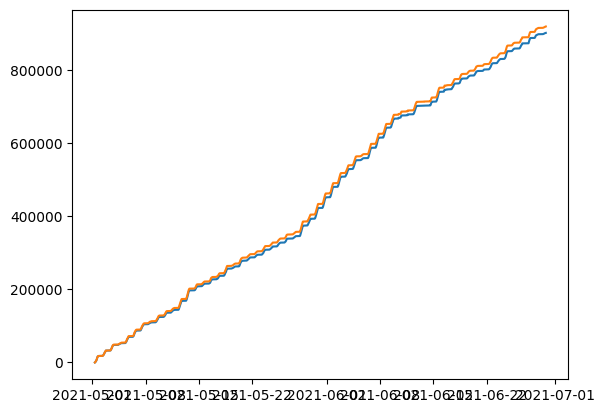

In [15]:
plt.plot((filtered_x*31.69).cumsum())
plt.plot(filtered_y.cumsum())

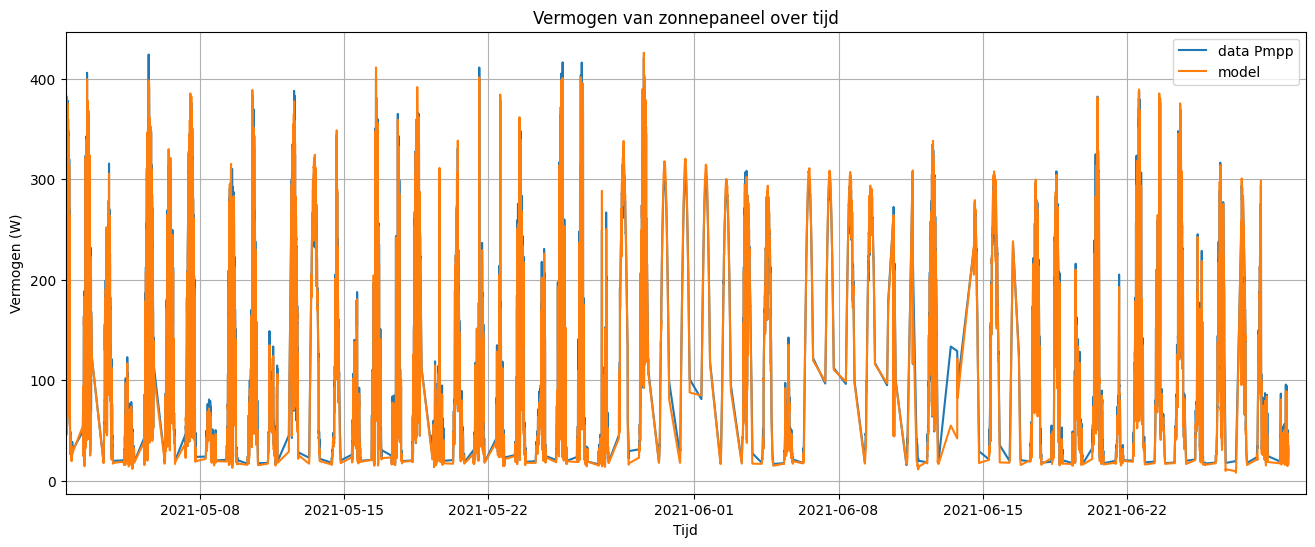

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(data['Pmpp[W]_3 (Solarpanel parameters)'],label='data Pmpp')
plt.plot(mc.results.dc*31.71,label='model')
#plt.plot(data['G[W/mï½²]_3 (Solarpanel parameters)'],label='data')
#plt.plot(data['G_pyranometer[W/mï½²]_3 (Solarpanel parameters)'],label='data pyranometer')

plt.legend()
plt.xlim(pd.Timestamp('2021-05-01 12:00:00'), pd.Timestamp('2021-06-30 16:00:00'))
plt.xlabel('Tijd')
plt.ylabel('Vermogen (W)')
plt.title('Vermogen van zonnepaneel over tijd')
plt.grid()


# Oude Simulatie

In [127]:
locatie_naam = "amolf"
latitude = 52.3676
longitude = 4.9041
timezone = "Europe/Amsterdam"
surface_tilt = 45
surface_azimuth = 180 # south

location = Location(latitude, longitude, tz=timezone, name=locatie_naam)

In [128]:
module_data = {
    "Vintage": 2017,
    "Area": 1.675*1.001,
    "Material": "c-Si",
    "Cells_in_Series": 60,
    "Parallel_Strings": 1,
    "Isco": 8.88,
    "Voco": 38,
    "Impo": 8.32,
    "Vmpo": 30.9,
    "Aisc":  0.081, 
    "Aimp": 0.000181, #deze niet
    "C0": 1.01284, #deze niet
    "C1": -0.01284, #deze niet
    "Bvoco": -0.37,  
    "Mbvoc": 0, #deze niet
    "Bvmpo": -0.45,
    "Mbvmp": 0, #deze niet
    "N": 1.4032,  #deze niet
    "C2": 0.279317,  #deze niet
    "C3": -7.24463,  #deze niet
    "A0": 0.928385,  #deze niet
    "A1": 0.068093,  #deze niet
    "A2": -0.015774,  #deze niet
    "A3": 0.001661,  #deze niet
    "A4": -0.000069,  #deze niet
    "B0": 1,  #deze niet
    "B1": -0.002438,  #deze niet
    "B2": 0.00031,  #deze niet
    "B3": -0.000012,  #deze niet
    "B4": 0.0,  #deze niet
    "B5": -0.0,  #deze niet
    "DTC": 3.0,  #deze niet
    "FD": 1,  #deze niet
    "A": -3.40641,  #deze niet
    "B": -0.084208,  #deze niet
    "C4": 0.996446,  #deze niet
    "C5": 0.003554,  #deze niet
    "IXO": 4.97599,  #deze niet
    "IXXO": 3.18803,  #deze niet
    "C6": 1.15535,  #deze niet
    "C7": -0.155353,  #deze niet
    "Notes": "Source: Sandia National Laboratories Updated 9/25/2012 Module Database"
}

In [129]:
sandai_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('CECInverter')

module = sandai_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

In [130]:
module['Vintage'] = module_data['Vintage']
module['Area'] = module_data['Area']
module['Material'] = module_data['Material']
module['Cells_in_Series'] = module_data['Cells_in_Series']
module['Parallel_Strings'] = module_data['Parallel_Strings']
module['Isco'] = module_data['Isco']
module['Voco'] = module_data['Voco']
module['Impo'] = module_data['Impo']
module['Vmpo'] = module_data['Vmpo']
module['Aisc'] = module_data['Aisc']
module['Aimp'] = module_data['Aimp']
module['C0'] = module_data['C0']
module['C1'] = module_data['C1']
module['Bvoco'] = module_data['Bvoco']
module['Mbvoc'] = module_data['Mbvoc']
module['Bvmpo'] = module_data['Bvmpo']
module['Mbvmp'] = module_data['Mbvmp']
module['N'] = module_data['N']
module['C2'] = module_data['C2']
module['C3'] = module_data['C3']
module['A0'] = module_data['A0']
module['A1'] = module_data['A1']
module['A2'] = module_data['A2']
module['A3'] = module_data['A3']
module['A4'] = module_data['A4']
module['B0'] = module_data['B0']
module['B1'] = module_data['B1']
module['B2'] = module_data['B2']
module['B3'] = module_data['B3']
module['B4'] = module_data['B4']
module['B5'] = module_data['B5']
module['DTC'] = module_data['DTC']
module['FD'] = module_data['FD']
module['A'] = module_data['A']
module['B'] = module_data['B']
module['C4'] = module_data['C4']
module['C5'] = module_data['C5']
module['IXO'] = module_data['IXO']
module['IXXO'] = module_data['IXXO']
module['C6'] = module_data['C6']
module['C7'] = module_data['C7']
module['Notes'] = module_data['Notes']

In [131]:
module

Vintage                                                          2017
Area                                                         1.676675
Material                                                         c-Si
Cells_in_Series                                                    60
Parallel_Strings                                                    1
Isco                                                             8.88
Voco                                                               38
Impo                                                             8.32
Vmpo                                                             30.9
Aisc                                                            0.081
Aimp                                                         0.000181
C0                                                            1.01284
C1                                                           -0.01284
Bvoco                                                           -0.37
Mbvoc               

In [132]:
temperature_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

In [133]:
system = PVSystem(surface_tilt=surface_tilt, surface_azimuth=surface_azimuth,
                  module_parameters=module, inverter_parameters=inverter,
                  temperature_model_parameters=temperature_parameters,
                  modules_per_string=1, strings_per_inverter=4)

In [134]:
modelchain = ModelChain(system, location)

In [156]:
# Kopieer de DataFrame om de originele data niet te wijzigen.
data = synced_df.copy()

# 2. Weerdata voorbereiden
weather = pd.DataFrame(index=data.index)
weather["temp_air"] = data.get("Avg Air Temperature (WeatherStation)", 20.0)
# Zet windsnelheid om van km/h naar m/s
weather["wind_speed"] = data.get("Avg Wind Speed [km/h] (WeatherStation)", 3.6) / 3.6
weather["ghi"] = data["G_pyranometer[W/mï½²]_3 (Solarpanel parameters)"]
weather['temp_dew']= data.get("Avg Dewpoint Temperature (WeatherStation)", 20.0)

weather["dni"] = data["G[W/mï½²]_3 (Solarpanel parameters)"]
weather["dhi"] = data["G_pyranometer[W/mï½²]_3 (Solarpanel parameters)"] - weather["dni"] * np.cos(np.radians(surface_tilt))

#weather["dni"] = data["G[W/mï½²]_3 (Solarpanel parameters)"]
#
#weather["dhi"] = data["G_pyranometer[W/mï½²]_3 (Solarpanel parameters)"] - weather["dni"] * np.cos(np.radians(surface_tilt))

# solpos = pvlib.solarposition.get_solarposition(weather.index, latitude, longitude)
# 
# # Schat DHI en DNI met het Erbs-model
# output = pvlib.irradiance.erbs(weather["ghi"], solpos['zenith'], weather.index)

# weather["dni"] = output["dni"]
# weather["dhi"] = output["dhi"]

<Axes: xlabel='datetime'>

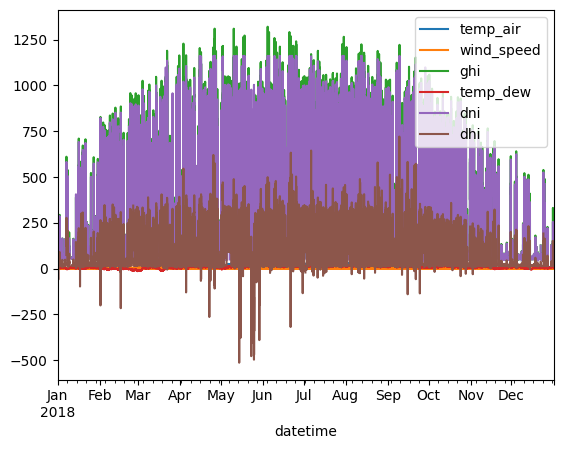

In [157]:
weather.plot()

In [158]:
## Bereken de zenith-hoek van de zon
#solpos = pvlib.solarposition.get_solarposition(weather.index, latitude, longitude)
#weather['zenith'] = solpos['zenith']
#
## Schat DNI met het DIRINT-model
#dni_dirint = pvlib.irradiance.dirint(
#    weather['ghi'],
#    weather['zenith'],
#    weather.index,
#    temp_dew=weather.get('temp_dew')  # Gebruik temp_dew als deze beschikbaar is
#)
#weather['dni'] = dni_dirint
#
## Bereken DHI op basis van GHI en de geschatte DNI
#weather['dhi'] = weather['ghi'] - weather['dni'] * np.cos(np.radians(weather['zenith']))

In [159]:
#weather.plot()

In [160]:
modelchain.run_model(weather=weather)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

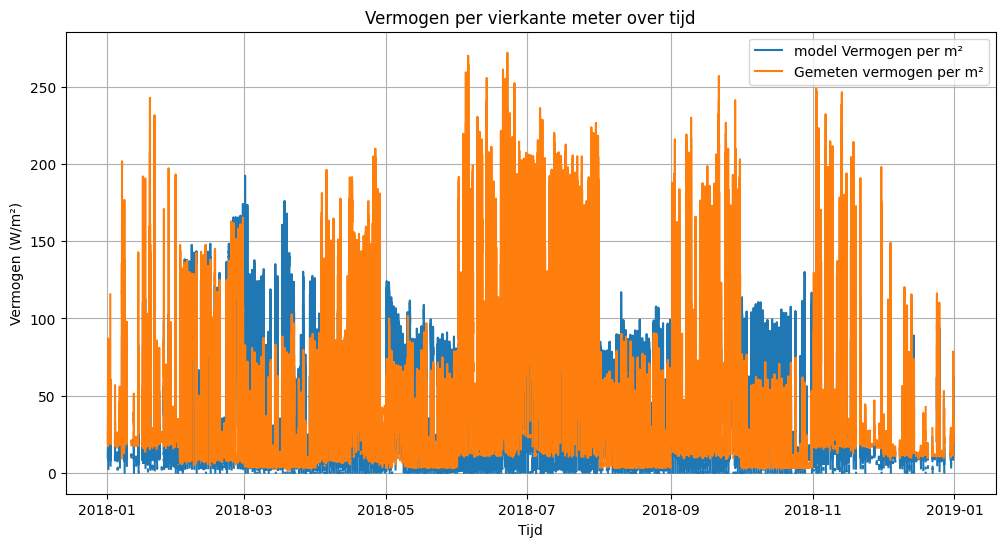

In [165]:
# Haal de DC-output van de modelchain op (in Watt)
dc_power = modelchain.results.dc['p_mp']  # 'p_mp' is het maximale DC-vermogen per tijdstap

# Parameters van je zonnepaneelsysteem
aantal_panelen = 4            # Vervang dit door het werkelijke aantal panelen
oppervlak_paneel = 1.65  # Oppervlak van één paneel in m² (voorbeeld: 1,65 m x 1,0 m)
totale_oppervlakte = aantal_panelen * oppervlak_paneel

# Bereken het vermogen per m²
vermogen_per_m2 = dc_power / totale_oppervlakte

# Plot het vermogen per m² over de tijd
plt.figure(figsize=(12, 6))
plt.plot(dc_power.index, vermogen_per_m2, label="model Vermogen per m²")
plt.plot(synced_df.index, synced_df['Pmpp[W]_3 (Solarpanel parameters)'], label="Gemeten vermogen per m²")
plt.xlabel("Tijd")
plt.ylabel("Vermogen (W/m²)")
plt.title("Vermogen per vierkante meter over tijd")
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='datetime'>

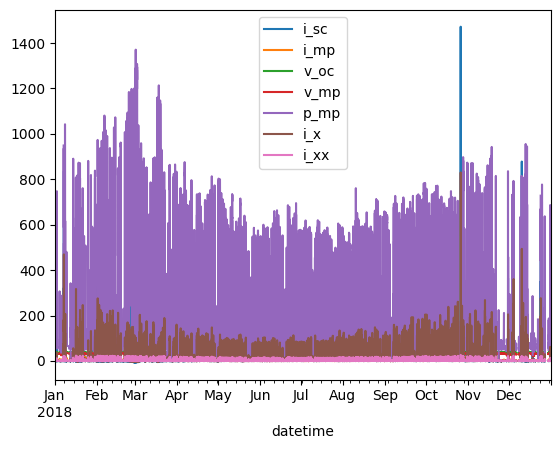

In [139]:
modelchain.results.dc.plot()

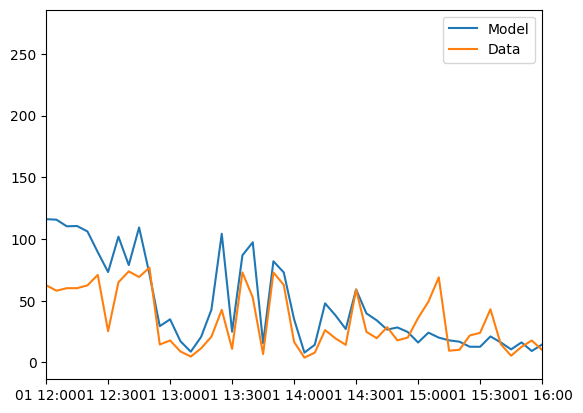

In [145]:
plt.plot(synced_df.index, modelchain.results.dc.p_mp/6.4, label='Model')
plt.plot(synced_df.index, synced_df['Pmpp[W]_3 (Solarpanel parameters)'], label='Data')
plt.xlim(pd.Timestamp('2018-10-01 12:00:00'), pd.Timestamp('2018-10-01 16:00:00'))
plt.legend()

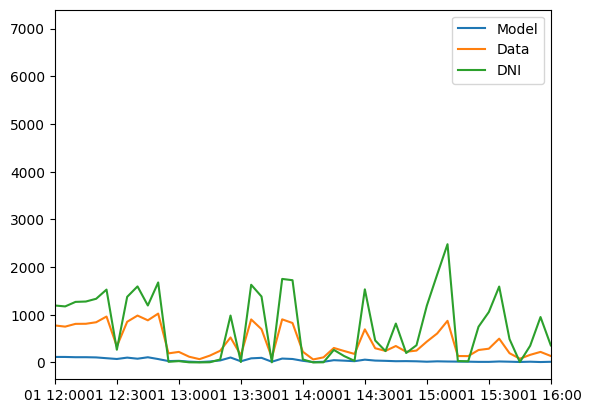

In [144]:
plt.plot(synced_df.index, modelchain.results.dc.p_mp, label='Model')
plt.plot(synced_df.index, synced_df['G[W/mï½²]_3 (Solarpanel parameters)'], label='Data')
plt.plot(synced_df.index, weather['dni'], label='DNI')
#plt.plot(synced_df.index, weather['ghi'], label='GHI')
plt.xlim(pd.Timestamp('2018-10-01 12:00:00'), pd.Timestamp('2018-10-01 16:00:00'))
plt.legend()

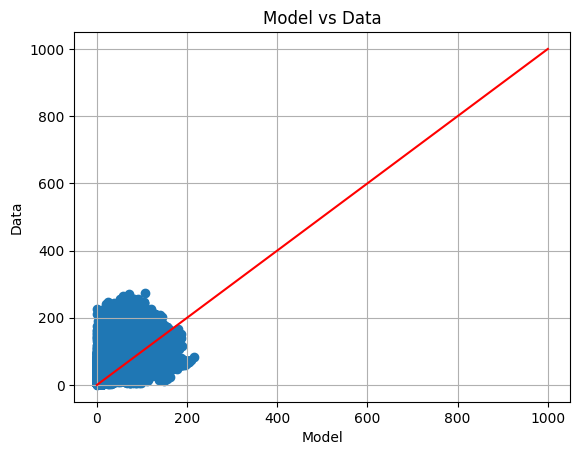

In [147]:
plt.scatter(modelchain.results.dc.p_mp, synced_df['G[W/mï½²]_3 (Solarpanel parameters)'])
plt.xlabel('Model')
plt.ylabel('Data')
plt.title('Model vs Data')
plt.grid()
#plot y =x lijn erdoorheen
x = np.linspace(0, 1000, 100)
plt.plot(x, x, 'r')

<Axes: xlabel='datetime'>

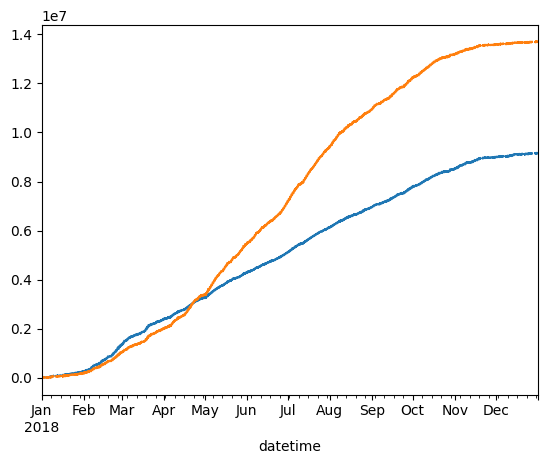

In [143]:
modelchain.results.dc.p_mp.cumsum().plot()
synced_df['G[W/mï½²]_3 (Solarpanel parameters)'].cumsum().plot()